In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 23 01:27:06 2020

@author: aniruddha maiti
"""

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import scipy.stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

# Part 2. Data Analyses



### Inference Task
Read the datasets and print them to understand the variables

In [91]:
# Patient_feature_matrix.csv – the analytic dataset to use for this task
# patient_feature_matrix 3455 x 2400
patient_feature_matrix = pd.read_csv('patient_feature_matrix.csv') 

# Feature_descriptions.csv – descriptions of the features in 
# patient_feature_matrix and their provenance
# feature_descriptions 2438 x 4
feature_descriptions = pd.read_csv('feature_descriptions.csv') 

#Cohort.csv -- contains the index time, exposure time (if any), 
# in-hospital time of death (if any), and the time of censoring 
# (when the patient was released from the hospital)
# cohort 3455 x 8
cohort = pd.read_csv('cohort.csv')


#### Know the data : -> in detail ####

In [3]:
patient_feature_matrix.head()

,subject_id,death_in_stay,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,...,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
0,91,died,stable,F,29809.000000,0,0,0,0,0,...,1.50000,1.700000,14.800000,42.400000,77.000000,3.900000,3.040000,144.000000,6.50000,15.0
1,106,died,oxy_drop,M,10358.333333,0,0,0,0,0,...,1.40027,2.600000,14.755973,35.507768,226.000000,3.700000,5.600000,136.000000,26.00000,11.0
2,111,survived,oxy_drop,F,24388.979167,0,0,0,0,0,...,1.40027,2.012763,12.200000,53.500000,208.493109,4.101856,3.535677,139.220795,12.65352,13.0
3,117,died,oxy_drop,F,18224.075000,0,0,0,0,0,...,1.90000,2.300000,17.200000,40.100000,42.000000,5.000000,2.310000,136.000000,7.00000,11.0
4,3,survived,oxy_drop,M,27951.375000,0,0,0,0,0,...,1.50000,2.300000,14.400000,36.200000,359.000000,4.400000,3.300000,138.000000,24.40000,11.0


In [4]:
feature_descriptions.head()

,feature,feature_type,code,description
0,icd9_.ADENOID.CYSTIC.CARCINOMA.SDA,icd9,.ADENOID.CYSTIC.CARCINOMA.SDA,.ADENOID.CYSTIC.CARCINOMA.SDA
1,icd9_.INTRACTABLE.EPILEPSY.SDA,icd9,.INTRACTABLE.EPILEPSY.SDA,.INTRACTABLE.EPILEPSY.SDA
2,icd9_.AORTIC.DISSECTION,icd9,.AORTIC.DISSECTION,.AORTIC.DISSECTION
3,icd9_.TIA.IV.HEPARIN,icd9,.TIA.IV.HEPARIN,.TIA.IV.HEPARIN
4,icd9_.ETT.CATH,icd9,.ETT.CATH,.ETT.CATH


In [5]:
cohort.head()

,subject_id,icustay_id,death_in_stay,deathtime,censor_time,index_time,exposure_time,oxy_drop
0,91,256972,died,2177-05-10 15:16:00,2177-05-10 15:16:00,2177-05-08 00:00:00,NaN,stable
1,106,252051,died,2192-08-15 21:15:00,2192-08-15 21:15:00,2192-08-10 08:00:00,2192-08-14 16:33:00,oxy_drop
2,111,254245,survived,NaN,2142-05-05 11:45:00,2142-04-24 23:30:00,2142-04-25 18:32:00,oxy_drop
3,117,217966,died,2133-12-01 17:00:00,2133-12-01 17:00:00,2133-11-20 01:48:00,2133-11-20 04:05:00,oxy_drop
4,3,211552,survived,NaN,2101-10-31 13:58:00,2101-10-21 09:00:00,2101-10-21 09:46:00,oxy_drop


In [6]:
# See feature types
feature_descriptions.feature_type.unique()

array(['icd9', 'chartindicator', 'chartvalue', 'note CUI', 'demographic',
       'engineered'], dtype=object)

#### Inference Task: ####
**Question :** whether a sudden and sustained drop in oxygenation within the first 12 hours of hospitalization is predictive of hospital mortality.

In [13]:
# For the first question, we need only two variables - oxy_drop and death_in_stay
# but before that some questions.

# Is cohort and patient_feature_matrix are representing same set of patients?
print(len(cohort))
print(len(cohort.subject_id.unique()))
print(len(patient_feature_matrix))
print(len(patient_feature_matrix.subject_id.unique()))

# OK these are for single patients.

3455
3455
3455
3455


In [18]:
# check the possible values of the variables
print(cohort['death_in_stay'].unique())
print(cohort['oxy_drop'].unique())

['died' 'survived']
['stable' 'oxy_drop']


In [3]:
# lets take only the variables that we need to answer the first question
data = cohort[['subject_id', 'death_in_stay', 'oxy_drop']]
#data['death_in_stay'] = data['death_in_stay'].replace('died', 1)
#data['death_in_stay'] = data['death_in_stay'].replace('survived', 0)
data = data.replace({'death_in_stay':{'died':1, 'survived':0}, 'oxy_drop':{'oxy_drop':1, 'stable':0}})

data.head()

,subject_id,death_in_stay,oxy_drop
0,91,1,0
1,106,1,1
2,111,0,1
3,117,1,1
4,3,0,1


In [4]:
# How many deaths?
print("death in hospital ", data['death_in_stay'].sum())

# How many oxy drops?
print("Oxy drop count ", data['oxy_drop'].sum())

death in hospital  630
Oxy drop count  972


We know, correlation is probably not the best way to draw conclusion about this association,
still it can give us valuable information. Another such metric is Matthews correlation coefficient.

**phi coefficient** The Matthews correlation coefficient (phi coefficient) might be used here as a measure of the association between mortality and oxy drop. This measure (statistic) will work here as it takes into account class imbalances. It is generally regarded as a balanced measure which can be used with classes of very different size. The Matthews correlation coefficient is similar to the correlation coefficient ranging between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. But for two binary variables, the value of phi coefficient will be similar that of pearson correlation coefficient.

In [5]:
X = data['oxy_drop']
Y = data['death_in_stay']

corr=scipy.stats.pearsonr(X,Y)
print(corr)
print('Correlation between oxy_drop and death_in_stay is {0:2.4f} \n\n'.format(corr[0]))

# OK not good
# Lets verify phi coefficient, should be same
from sklearn.metrics import matthews_corrcoef
print("matthews corrcoef : ", matthews_corrcoef(Y, X))

(0.10295866297753335, 1.3132433794891265e-09)
Correlation between oxy_drop and death_in_stay is 0.1030 


matthews corrcoef :  0.102958662978


In [42]:
# Lets check out confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, X)

array([[2092,  733],
       [ 391,  239]])

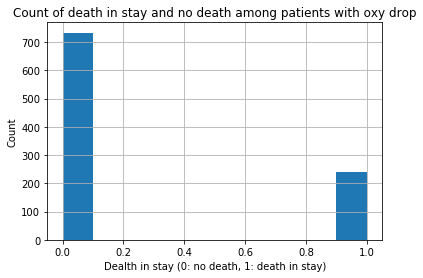

In [58]:
# How about just seeing the histograms
data[data['oxy_drop']==1].death_in_stay.hist() 
plt.xlabel('Dealth in stay (0: no death, 1: death in stay)')
plt.ylabel('Count')
plt.title("Count of death in stay and no death among patients with oxy drop")
plt.show()

# OK not good

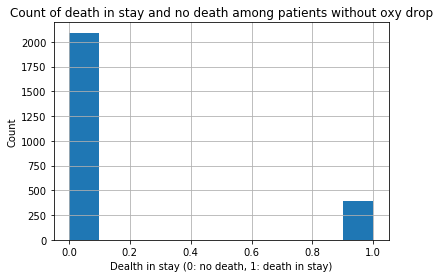

In [59]:
# How about among those who are alive
data[data['oxy_drop']==0].death_in_stay.hist() 
plt.xlabel('Dealth in stay (0: no death, 1: death in stay)')
plt.ylabel('Count')
plt.title("Count of death in stay and no death among patients without oxy drop")
plt.show()


# OK we are seeing something, yes probably oxy drop might translate to hostotal death

##### Mutual information ####### 
The mutual information between two random variables X and Y are defined as :
I(X;Y) = H(X)-H(X|Y). Here I(X;Y) is the mutual information for X and Y, H(X) is entropy of X and H(X|Y) is the conditional entropy of X given Y. This quantity is a measure of dependence between two random variables. We can use mutual information to calvulate the dependence between sudden and sustained drop in oxygenation and hospital mortality. Mutual information is greater than or equal to zero, if mutual information is high, the relationship between the two variables is also high. If the calculated result is zero, then the variables are independent. So mutual information can be used as a predictive power of a variable.

In [11]:
# mutual information, expressed in natural unit of information (nats)
# convert to numpy array
X1 = np.array(X).T
Y1 = np.array(Y).T
print(mutual_info_classif(X1.reshape(-1,1), Y1, discrete_features = True)) # have to reshape X1 
print(mutual_info_score(X1,Y1))

# OK , greater than zero, so there is soke dependency.

[ 0.00506635]
0.00506635355494


##### Inference Task #######
Whether a sudden and sustained drop in oxygenation within the first 12 hours of hospitalization is predictive of hospital mortality.

**Ans** One simple way to test the association would be Fisher exact test on the 2x2 contingency table. Chi-square test is not suitable as there are only two binary variables.

In [53]:
oddsratio, pvalue = scipy.stats.fisher_exact(confusion_matrix(Y, X))

In [54]:
# print odds ratio and p value of the test
oddsratio, pvalue

(1.7445316343513502, 3.570818717556666e-09)

### Prediction Task
#### Develop at least two types of models to predict hospitalization mortality, and evaluate their performance

In [3]:
# First check the data dimension

# Patient_feature_matrix.csv – the analytic dataset to use for this task
# patient_feature_matrix 3455 x 2400
print(patient_feature_matrix.shape)

# Feature_descriptions.csv – descriptions of the features in 
# patient_feature_matrix and their provenance
# feature_descriptions 2438 x 4
print(feature_descriptions.shape) 

#Cohort.csv -- contains the index time, exposure time (if any), 
# in-hospital time of death (if any), and the time of censoring 
# (when the patient was released from the hospital)
# cohort 3455 x 8
print(cohort.shape)

(3455, 2440)
(2438, 4)
(3455, 8)


In [14]:
# So we have to use patient_feature_matrix
patient_feature_matrix.head(n=10)

,subject_id,death_in_stay,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,...,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
0,91,died,stable,F,29809.000000,0,0,0,0,0,...,1.50000,1.700000,14.800000,42.400000,77.000000,3.900000,3.040000,144.000000,6.50000,15.0
1,106,died,oxy_drop,M,10358.333333,0,0,0,0,0,...,1.40027,2.600000,14.755973,35.507768,226.000000,3.700000,5.600000,136.000000,26.00000,11.0
2,111,survived,oxy_drop,F,24388.979167,0,0,0,0,0,...,1.40027,2.012763,12.200000,53.500000,208.493109,4.101856,3.535677,139.220795,12.65352,13.0
3,117,died,oxy_drop,F,18224.075000,0,0,0,0,0,...,1.90000,2.300000,17.200000,40.100000,42.000000,5.000000,2.310000,136.000000,7.00000,11.0
4,3,survived,oxy_drop,M,27951.375000,0,0,0,0,0,...,1.50000,2.300000,14.400000,36.200000,359.000000,4.400000,3.300000,138.000000,24.40000,11.0
5,31,died,oxy_drop,M,26396.000000,0,0,0,0,0,...,1.10000,1.700000,13.000000,28.500000,184.000000,3.700000,2.940000,133.000000,6.90000,11.0
6,36,survived,oxy_drop,M,25474.541667,0,0,0,0,0,...,1.50000,2.000000,16.000000,33.100000,270.000000,3.900000,3.810000,129.000000,21.90000,11.0
7,38,survived,oxy_drop,M,27738.986111,0,0,0,0,0,...,1.50000,2.000000,14.800000,32.000000,99.000000,3.800000,3.200000,138.000000,13.90000,10.0
8,357,survived,oxy_drop,M,22905.916667,0,0,0,0,0,...,1.10000,2.300000,13.200000,28.100000,111.000000,4.200000,3.910000,140.000000,10.50000,11.0
9,360,survived,stable,F,27900.291667,0,0,0,0,0,...,1.10000,2.700000,12.900000,24.700000,203.000000,4.100000,3.160000,142.000000,12.10000,11.0


In [143]:
# Summary Statistics
patient_feature_matrix.describe()

,subject_id,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,icd9_14-AAA,icd9_3RD DEGREE HEART BLOCK,"icd9_ABD PAIN, MASTOCYTOSIS",...,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
count,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,...,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000
mean,16320.206078,26136.337205,0.000579,0.002605,0.000579,0.002605,0.002605,0.003184,0.002026,0.002605,...,1.400270,2.012763,14.755973,35.507768,208.493109,4.101856,3.535677,139.220795,12.653520,12.831285
std,9515.710982,18407.117531,0.034026,0.153115,0.034026,0.153115,0.153115,0.187141,0.119090,0.153115,...,0.563578,0.447588,3.345759,16.949869,105.486320,0.585159,0.740401,4.547817,6.232274,1.853679
min,3.000000,5547.543056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.700000,8.200000,16.900000,6.000000,2.100000,1.240000,115.000000,0.100000,6.000000
25%,7942.000000,18406.939236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.200000,1.800000,13.200000,27.400000,140.000000,3.700000,3.170000,137.000000,8.800000,12.000000
50%,16351.000000,23892.673611,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.300000,2.000000,14.300000,32.000000,197.000000,4.100000,3.535677,139.000000,12.100000,13.000000
75%,24762.500000,28426.861111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.400270,2.200000,14.900000,35.507768,252.000000,4.400000,3.840000,142.000000,14.900000,14.000000
max,32790.000000,111718.125000,2.000000,9.000000,2.000000,9.000000,9.000000,11.000000,7.000000,9.000000,...,12.100000,14.000000,77.100000,150.000000,1064.000000,7.100000,31.799999,177.000000,96.600000,23.000000


In [92]:
# Are all features numeric?
all_features = list(patient_feature_matrix)
# exclude subject_id and target (death_in_stay)
exclude = ['subject_id', 'death_in_stay']

all_features = [k for k in all_features if k not in exclude]
#print(all_features)

# feature matrix
Feature_Matrix = patient_feature_matrix[all_features]
# If X.sum() works then all are numeric, if exception, then there are categorical values
print(Feature_Matrix['gender'].head())
# OK -> gender is obviously categorical, we have to do categorical encoding
# Also we know oxy_drop is categorical
# But the good thing is that they are both binary, so 0/1 encoding will work.


# We do one hot encoding of categorical variables as follows
# but this will create new names for dummy variable, cumbersome to handle
#Feature_Matrix = pd.get_dummies(Feature_Matrix)
#

# Rather do it manually, only two features
#Convert categorical features to 0/1
Feature_Matrix = Feature_Matrix.replace({'gender':{'F':1, 'M':0}, 'oxy_drop':{'oxy_drop':1, 'stable':0}})
Feature_Matrix.head(n=5)

0    F
1    M
2    F
3    F
4    M
Name: gender, dtype: object


,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,icd9_14-AAA,icd9_3RD DEGREE HEART BLOCK,...,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
0,0,1,29809.000000,0,0,0,0,0,0,0,...,1.50000,1.700000,14.800000,42.400000,77.000000,3.900000,3.040000,144.000000,6.50000,15.0
1,1,0,10358.333333,0,0,0,0,0,0,0,...,1.40027,2.600000,14.755973,35.507768,226.000000,3.700000,5.600000,136.000000,26.00000,11.0
2,1,1,24388.979167,0,0,0,0,0,0,0,...,1.40027,2.012763,12.200000,53.500000,208.493109,4.101856,3.535677,139.220795,12.65352,13.0
3,1,1,18224.075000,0,0,0,0,0,0,0,...,1.90000,2.300000,17.200000,40.100000,42.000000,5.000000,2.310000,136.000000,7.00000,11.0
4,1,0,27951.375000,0,0,0,0,0,0,0,...,1.50000,2.300000,14.400000,36.200000,359.000000,4.400000,3.300000,138.000000,24.40000,11.0


In [93]:
# craete target variable
Y = patient_feature_matrix['death_in_stay']

# select features
all_features = [k for k in Feature_Matrix]

In [32]:
# Step 1 : we have to reduce dimensionality. 2440 is too high, the problem would otherwise become overcomplete 
#(not in true sense!!!, because the number of instances would still be greater).

# How to detect important features?
# Principal Component Analysis (PCA) - will not work not interpretable
# Singular Value Decomposition (SVD) - will not work not interpretable

# How about Manifold learning methods - Isomap Embedding, tSNE? Same problem, not interpretable.




In [7]:
# Some analysis
#Gender distribution
print("Female : ", Feature_Matrix['gender'].sum())
print("Male : ", len(Feature_Matrix)-Feature_Matrix['gender'].sum())

Female :  1585
Male :  1870


#### Feature Selction
We need to use some method for feature selection that is interpretable. Good thing about this problem is the target variable has only two labels, that is we can convert the target variable as 1/0 variable. Same thing for features, we have only 'gender' as categorical, it is easy to covert it to either 1/0 or one hot. So we have a number of options at our disposal. We can either use any of these combination for statistical tests : categorical->numeric, numeric->numeric, numeric->categorical, categorical->categorical.

##### Interpretability
To maintain interpretability, we will not use any feature reduction method that transforms the original basis. Rather we will use standard statistical tests o identify good features.

#### Non-negative features
Tests like Chi-square requires non negative features. We have to check that one first.

####################################
chartvalue_776  has non negative value  -24.0
code  1863    776
Name: code, dtype: object
description  1863    Arterial Base Excess
Name: description, dtype: object


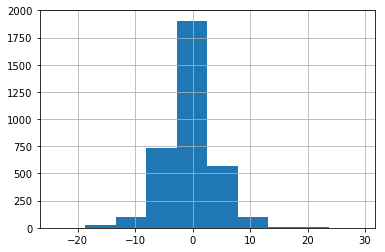

####################################
chartvalue_777  has non negative value  -6.0
code  1864    777
Name: code, dtype: object
description  1864    Arterial CO2(Calc)
Name: description, dtype: object


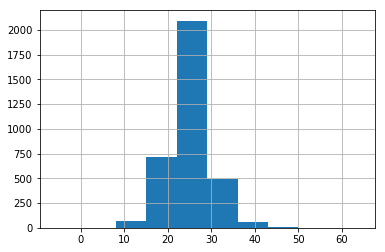

In [44]:
# check if there is any feature which is non-negative,.
for fea in all_features:
    if Feature_Matrix[fea].min() < 0.0:
        print("####################################")
        print(fea, " has non negative value ", Feature_Matrix[fea].min())        
        # What are these features?
        print("code ", feature_descriptions[feature_descriptions['feature']==fea].code)
        print("description ", feature_descriptions[feature_descriptions['feature']==fea].description)
        Feature_Matrix[fea].hist()
        plt.show()

In [95]:
# Normalize features -> will solve the problem of negative values, 
#additionally, this step will hlp subseuent modelling
from sklearn import preprocessing
# first save the feature list, min max scaler will transform the data to numpy.ndarray
all_features = [k for k in Feature_Matrix]
# now transform using min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
Feature_Matrix = min_max_scaler.fit_transform(Feature_Matrix)

#### Two Step Feature selection scheme
We will employ a two step scheme to select best features. We ideally would like to use **feature ranking with recursive feature elimination (RFE) scheme**, but this startegy is exponential on the number of features. For a large number of features, this scheme will be very slow. Therefore, we will first use a **Chi-square based** test to identify a few promising features, then we will employ **RFE** scheme to select the best ones. The reason we want to use **RFE** scheme is that this method essentially uses an underlying machine learning model to evaluate the feature importance. If the underlying model is some interpretable model like logistic regression or ridge regression, then we can one hand easily identify the features, understand their contribution in the model. Additionally, we can solve two problems at once : feature selection and predictive model buildig.



#### Step 1: Select a few promising features (n=20) using Chi-Square
First we will use Chi-square based test to identify a few promising features. We can employ Chi-square scores as a feature selection criteria, interpreting the prediction task as a classification task. 

We will use sklearn wrapper SlectKBest. Good thing about this wrapper is that we can employ multiple testing criteria in pipeline to select good features. In case we want to use something else (such as mutual information, f_regression etc.) we can do it quickly by changing the score function.

In [96]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# do experiment with k =5, 10, 20
fea_test = SelectKBest(score_func=chi2, k=40)
test_model = fea_test.fit(Feature_Matrix, Y)

# scores
print(test_model.scores_)
# p values
print(test_model.pvalues_)

# Subset of features
transformed_data_chi2 = test_model.transform(Feature_Matrix)

# Summarize  features
print(transformed_data_chi2.shape)

[ 26.32100744   1.22065221  12.40676299 ...,   0.41410211   1.01649109
   3.35644594]
[  2.89126635e-07   2.69232693e-01   4.27781752e-04 ...,   5.19894744e-01
   3.13352781e-01   6.69423966e-02]
(3455, 40)


Let us check if 20 features are sufficient or not. We might miss out a few good features if this cut-off is not good.

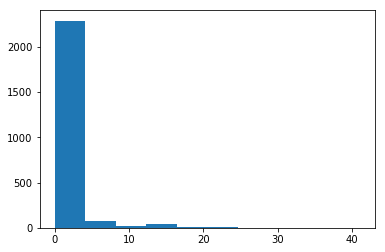

[2286, 70, 18, 45, 5, 5, 3, 2, 0, 3]
[  0.    4.1   8.2  12.3  16.4  20.5  24.6  28.7  32.8  36.9  41. ]


In [52]:
# there is a bug(?) in test_model.scores_, sometime it returs nan
import math
def isnan(value):
    try:        
         return math.isnan(float(value))
    except:
         return False

sc = [int(x) for x in test_model.scores_ if not isnan(x)]

n, bins, patches = plt.hist(sc, 10)
plt.show()
print([int(k) for k in n])
print(bins)

# OK, we did well by selecting 20, it seems top 18 features are good enough.

In [25]:
selected_feature_indices = test_model.get_support(indices=True)
selected_features_chi2 = []
# Print Selected Features
for fea_ind in selected_feature_indices:
    fea = all_features[fea_ind]
    selected_features_chi2.append(fea)
    # What are these features?
    score = "{0:1.2f}".format(test_model.scores_[fea_ind])
    pval = "{:.2e}".format(test_model.pvalues_[fea_ind])

    code = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].code
    description = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].description
    print("feature : ", fea, "code :", code, " description : ", description, " score : ", score)
    #print(code, '&' ,description, '&' , score, '&' , pval, '\\\\')



feature :  oxy_drop code : nan  description :  sustained drop in oxygenation after stable ventilation  score :  26.32
feature :  C0264221 code : C0264221  description :  disorder of upper respiratory system  score :  15.54
feature :  C0395797 code : C0395797  description :  ear, nose and throat disorder  score :  15.54
feature :  C0574123 code : C0574123  description :  ear, nose and throat finding  score :  15.54
feature :  C0575141 code : C0575141  description :  finding of head and neck region  score :  15.54
feature :  C0577872 code : C0577872  description :  upper respiratory tract finding  score :  15.54
feature :  chartindicator_116 code : 116  description :  Cardiac Index  score :  17.46
feature :  chartindicator_123 code : 123  description :  Chest Tube Site #2  score :  20.24
feature :  chartindicator_1390 code : 1390  description :  DO2  score :  15.55
feature :  chartindicator_1401 code : 1401  description :  zzO2AV  score :  15.66
feature :  chartindicator_1402 code : 1402

#### Step 2 : RFE based feature selection from promising features followed by a Predictive Modelling using ridge regression

In step 2, we will use RFE based search to select good features. 

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


# How many features?
# let us employ a search use logistic regression as underlying model to score
num_fea_array = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]
for fea_count in num_fea_array:
    lr_model = LogisticRegression() # use logistic regression as underlying model to score features
    rfe = RFE(lr_model, fea_count)
    fit = rfe.fit(transformed_data_chi2, Y)

    #print("Selected Features: %s" % (fit.support_))
    score = fit.score(transformed_data_chi2, Y)
    print("Feature count : ", fea_count, "Score : ", score)
    #print("Feature Ranking: %s" % (fit.ranking_))
    

Feature count :  1 Score :  0.817655571635
Feature count :  3 Score :  0.817655571635
Feature count :  5 Score :  0.817655571635
Feature count :  10 Score :  0.817655571635
Feature count :  15 Score :  0.817655571635
Feature count :  20 Score :  0.819102749638
Feature count :  25 Score :  0.814471780029
Feature count :  30 Score :  0.814182344428
Feature count :  35 Score :  0.814182344428
Feature count :  40 Score :  0.814182344428


RFE based search for a few best features reveal some new things. It seems even if we reduce number of features we do not loose information, rather using only the top feature makes things better. Let us use top 10 features and check what are they.

In [99]:
lr_model = LogisticRegression() 
rfe = RFE(lr_model, 10)
fit = rfe.fit(transformed_data_chi2, Y)

#print("Selected Features: %s" % (fit.support_))
score = fit.score(transformed_data_chi2, Y)
transformed_data_rfe = fit.fit_transform(transformed_data_chi2, Y)

selected_features_rfe = np.array(selected_features_chi2)[fit.support_]

# Print Selected Features
for fea in selected_features_rfe:
    code = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].code
    description = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].description
    print("feature : ", fea, "code :", code, " description ", description)
    #print(code, '&' ,description, '\\\\')

feature :  chartindicator_116 code : 116  description  Cardiac Index
feature :  chartindicator_123 code : 123  description  Chest Tube Site #2
feature :  chartindicator_1695 code : 1695  description  Atr Sens Thresh mV
feature :  chartindicator_431 code : 431  description  LVSWI
feature :  chartindicator_518 code : 518  description  Pacer Wire Condition
feature :  chartindicator_519 code : 519  description  Pacer Wires Atrial
feature :  chartindicator_627 code : 627  description  SVRI
feature :  chartindicator_94 code : 94  description  CT #1 Drainage
feature :  chartindicator_95 code : 95  description  CT #1 Dressing
feature :  chartvalue_454 code : 454  description  Motor Response


One interesting fact, the primary predictor **oxy_drop** itself turned out to be not good enough, there are some other good features, at least according to RFE with logistic regression. It it because of logistic regression? Logistic regression uses logistic function to transform the linear model in between 0-1. That transformation might interpret things differently. How about SVM based score?

In [100]:
from sklearn.svm import SVC
num_fea_array = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

for fea_count in num_fea_array:
    svc_model  = SVC(kernel="linear") # use support vector machine as underlying model to score features
    rfe = RFE(svc_model, fea_count)
    fit = rfe.fit(transformed_data_chi2, Y)

    #print("Selected Features: %s" % (fit.support_))
    score = fit.score(transformed_data_chi2, Y)
    print("Feature count : ", fea_count, "Score : ", score)
    #print("Feature Ranking: %s" % (fit.ranking_))


Feature count :  1 Score :  0.817655571635
Feature count :  3 Score :  0.817655571635
Feature count :  5 Score :  0.817655571635
Feature count :  10 Score :  0.817655571635
Feature count :  15 Score :  0.817655571635
Feature count :  20 Score :  0.817655571635
Feature count :  25 Score :  0.817655571635
Feature count :  30 Score :  0.817655571635
Feature count :  35 Score :  0.817655571635
Feature count :  40 Score :  0.817655571635


OK, same story. Let us do some sanity check using sklearn SVC directly for all 40 features.

In [73]:
# sanity check
svc_model  = SVC(kernel="linear")
fit = svc_model.fit(transformed_data_chi2, Y)
score = fit.score(transformed_data_chi2, Y)
print("Score : ", score)

# OK, we are good. Problem is we have a very sparse data, that is causing this type of problem.

Score :  0.817655571635


We used logistic regression as a baseline in RFE, but problem with logistic regression is it does not regularize. Therefore in we will use a model that can regularize, ridge regression might be a good choice. But ridge regression is a regression task, we have to transform the target variable Y to binary (0/1) before using ridge regression.


#### Predictive Model 1 : Ridge regression #####
||y - Xw||^2_2 + alpha * ||w||^2_2


In [101]:
from sklearn.linear_model import Ridge

# First use RFE to select features
lr_model = LogisticRegression() 
rfe = RFE(lr_model, 10)
fit = rfe.fit(transformed_data_chi2, Y)
transformed_data_rfe = fit.fit_transform(transformed_data_chi2, Y)
selected_features_rfe = np.array(selected_features_chi2)[fit.support_]

# Convert target to 0/1
binary_target = Y.replace({'died':1, 'survived':0})
# Run ridge regression with mild regularization
ridge = Ridge(alpha=0.01, fit_intercept = False)
ridge.fit(transformed_data_rfe,binary_target)
print(ridge.coef_)
print(ridge.score(transformed_data_rfe, bimary_target))

# OK, something is wrong. I have not seen such a bad model in my life. 

[ 0.2553335  -0.14193563 -0.02054946 -0.21487708  0.01775914 -0.08759838
 -0.15242754  0.19206434 -0.31091423  0.18275022]
-0.0952927606089


In [102]:
# How about the 40 features selected by chi square?
ridge = Ridge(alpha=0.01, fit_intercept = False)
ridge.fit(transformed_data_chi2, binary_target)
print(ridge.coef_)
print(ridge.score(transformed_data_chi2, binary_target))

# Ok, did a little bit better, did we make some mistake somewhere?

[  1.64746478e-01   2.97308175e-02   2.97308175e-02   2.97308175e-02
   2.97308175e-02   2.97308175e-02  -2.55209044e-01  -8.99840989e-02
   2.45110666e-01   1.02824582e+00  -1.31481009e+00  -8.99083189e-02
   3.47873776e-02   2.06705962e-01   2.71494370e-04   5.41949545e-01
  -8.24625832e-01  -8.36711363e-01   9.37570866e-01  -3.28548574e-02
  -2.03861691e-02  -1.98477897e-02   5.96060174e-02  -9.10090975e-02
  -2.89016437e-01   4.90451895e-01  -2.11975891e-01  -5.42012976e-01
   5.57795560e-01   8.07456684e-02   1.66395911e-01  -1.84325019e-03
   1.38025220e-02  -9.15253187e-03  -9.29072429e-01  -8.82959015e-01
   1.54676011e+00  -8.24140659e-02  -2.74741319e-02   1.94392427e-01]
-0.0288928093476


Time for sanity check. Ridge regression did not do well. Wrong turn. Let us just check the correlation of all the 40 features with target.



In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import scipy.stats

# Read data

# Patient_feature_matrix.csv 
patient_feature_matrix = pd.read_csv('patient_feature_matrix.csv') 
# Feature_descriptions.csv
feature_descriptions = pd.read_csv('feature_descriptions.csv') 

# target variable
Y = patient_feature_matrix['death_in_stay']
all_features = list(patient_feature_matrix)
# exclude subject_id and target (death_in_stay)
exclude = ['subject_id', 'death_in_stay']
all_features = [k for k in all_features if k not in exclude]
# feature matrix
Feature_Matrix = patient_feature_matrix[all_features]
#Convert categorical features to 0/1
Feature_Matrix = Feature_Matrix.replace({'gender':{'F':1, 'M':0}, 'oxy_drop':{'oxy_drop':1, 'stable':0}})
Feature_Matrix.head(n=5)

,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,icd9_14-AAA,icd9_3RD DEGREE HEART BLOCK,...,chartvalue_815,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87
0,0,1,29809.000000,0,0,0,0,0,0,0,...,1.50000,1.700000,14.800000,42.400000,77.000000,3.900000,3.040000,144.000000,6.50000,15.0
1,1,0,10358.333333,0,0,0,0,0,0,0,...,1.40027,2.600000,14.755973,35.507768,226.000000,3.700000,5.600000,136.000000,26.00000,11.0
2,1,1,24388.979167,0,0,0,0,0,0,0,...,1.40027,2.012763,12.200000,53.500000,208.493109,4.101856,3.535677,139.220795,12.65352,13.0
3,1,1,18224.075000,0,0,0,0,0,0,0,...,1.90000,2.300000,17.200000,40.100000,42.000000,5.000000,2.310000,136.000000,7.00000,11.0
4,1,0,27951.375000,0,0,0,0,0,0,0,...,1.50000,2.300000,14.400000,36.200000,359.000000,4.400000,3.300000,138.000000,24.40000,11.0


In [2]:
# Normalize features 
from sklearn import preprocessing
# first save the feature list, min max scaler will transform the data to numpy.ndarray
all_features = [k for k in Feature_Matrix]
# now transform using min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
Feature_Matrix = min_max_scaler.fit_transform(Feature_Matrix)

In [3]:
# Do feature selection with chi-square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fea_test = SelectKBest(score_func=chi2, k=40)
test_model = fea_test.fit(Feature_Matrix, Y)

transformed_data_chi2 = test_model.transform(Feature_Matrix)
selected_feature_indices = test_model.get_support(indices=True)
selected_features_chi2 = []
# Print Selected Features
for fea_ind in selected_feature_indices:
    fea = all_features[fea_ind]
    selected_features_chi2.append(fea)

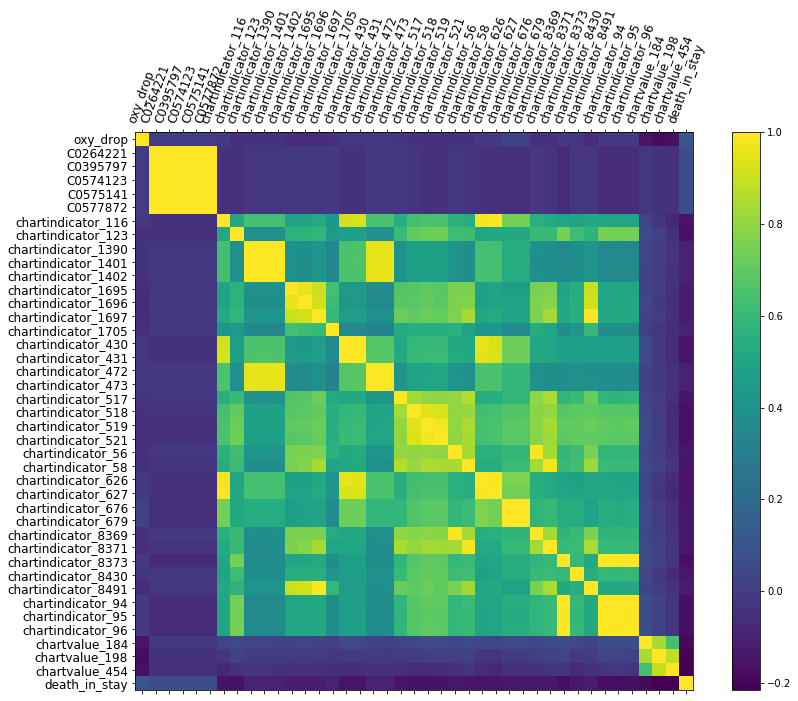

In [4]:
# Create subset of the selected features
fea_target = selected_features_chi2 + ["death_in_stay"]
chi2_dataframe = patient_feature_matrix[fea_target]

# make categorical features to binary
chi2_dataframe = chi2_dataframe.replace({'death_in_stay':{'died':1, 'survived':0}, 'gender':{'F':1, 'M':0}, 'oxy_drop':{'oxy_drop':1, 'stable':0}})

# Correlation matrix
import matplotlib.pyplot as plt
f = plt.figure(figsize=(14, 10))
plt.matshow(chi2_dataframe.corr(), fignum=f.number)
plt.xticks(range(chi2_dataframe.shape[1]), chi2_dataframe.columns, fontsize=12, rotation=70)
plt.yticks(range(chi2_dataframe.shape[1]), chi2_dataframe.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

# OK no wonder ridge regression score is so bad. Correlations of the features and the target are pretty low. 

**Few Observations**: RFE based search revealed that the score is same for different number of features. I suspect that there is redundancy. Also correlation matrix revealed that there is some redundency in features. This opens up two possibilities. Either use multivariate filter methods like mRMR to select uncorrelated good features or use some tree based methods that use feature importance and where correlated features get low score. We have few options for the second choice: Xgboost, random forest etc.

#### Predictive Modeling 1 : Xgboost

Boosting is an ensemble technique. Xgboost combines a set of weak learners to improved prediction accuracy. The main idea is that the outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

**Correlation with all the features**


In [5]:
# Read data

# Patient_feature_matrix.csv 
patient_feature_matrix = pd.read_csv('patient_feature_matrix.csv') 
# Feature_descriptions.csv
feature_descriptions = pd.read_csv('feature_descriptions.csv') 

# target variable
Y = patient_feature_matrix['death_in_stay']
all_features = list(patient_feature_matrix)
# exclude subject_id and target (death_in_stay)
exclude = ['subject_id', 'death_in_stay']
all_features = [k for k in all_features if k not in exclude]
# feature matrix
Feature_Matrix = patient_feature_matrix[all_features]
#Convert categorical features to 0/1
Feature_Matrix = Feature_Matrix.replace({'gender':{'F':1, 'M':0}, 'oxy_drop':{'oxy_drop':1, 'stable':0}})
#Feature_Matrix.head(n=5)

from sklearn import preprocessing
# first save the feature list, min max scaler will transform the data to numpy.ndarray
all_features = [k for k in Feature_Matrix]
# now transform using min max scaler
min_max_scaler = preprocessing.MinMaxScaler()
fea_data = min_max_scaler.fit_transform(Feature_Matrix)
fea_and_target = pd.DataFrame(data=fea_data, columns=all_features)
fea_and_target['death_in_stay'] = patient_feature_matrix['death_in_stay'].replace({'died':1, 'survived':0})
fea_and_target.head()

,oxy_drop,gender,age_in_days,icd9_ ADENOID CYSTIC CARCINOMA/SDA,icd9_ INTRACTABLE EPILEPSY/SDA,icd9_?AORTIC DISSECTION,icd9_?TIA;IV HEPARIN,icd9_+ETT\CATH,icd9_14-AAA,icd9_3RD DEGREE HEART BLOCK,...,chartvalue_821,chartvalue_824,chartvalue_825,chartvalue_828,chartvalue_829,chartvalue_833,chartvalue_837,chartvalue_861,chartvalue_87,death_in_stay
0,0.0,1.0,0.228514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075188,0.095791,0.191585,0.067108,0.360000,0.058901,0.467742,0.066321,0.529412,1
1,1.0,0.0,0.045312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.095152,0.139803,0.207940,0.320000,0.142670,0.338710,0.268394,0.294118,1
2,1.0,1.0,0.177464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.098704,0.058055,0.274981,0.191392,0.400371,0.075120,0.390658,0.130088,0.411765,0
3,1.0,1.0,0.119398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120301,0.130624,0.174305,0.034026,0.580000,0.035013,0.338710,0.071503,0.294118,1
4,1.0,0.0,0.211017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.120301,0.089985,0.145004,0.333648,0.460000,0.067408,0.370968,0.251813,0.294118,0


In [6]:
# calculate correlation matrix
corr_matrix = fea_and_target.corr()

In [7]:
print(corr_matrix.shape)
# check highest values
corr_matrix['death_in_stay'].nlargest(n=10)

(2439, 2439)


death_in_stay         1.000000
chartvalue_781        0.178333
age_in_days           0.152230
chartvalue_450        0.145449
chartindicator_208    0.132647
chartindicator_137    0.129727
chartindicator_784    0.124969
chartindicator_836    0.124657
chartvalue_811        0.121993
chartindicator_135    0.114511
Name: death_in_stay, dtype: float64

In [103]:
# negative correlation is also important
corr_matrix['death_in_stay'].sort_values(ascending=True).head(n=10)

chartvalue_198        -0.216262
chartvalue_454        -0.216233
chartvalue_184        -0.188326
chartvalue_87         -0.181226
chartindicator_94     -0.167899
chartindicator_95     -0.167611
chartindicator_8373   -0.165432
chartindicator_96     -0.165357
chartindicator_122    -0.163150
chartindicator_97     -0.161976
Name: death_in_stay, dtype: float64

In [11]:
# apply absolute and then take top 10
abs_corr = corr_matrix['death_in_stay'].apply(lambda x: abs(x))

correlation_based_fea = []
for row in abs_corr.nlargest(n=20).index:
    if row!='death_in_stay':
        correlation_based_fea.append(row)

abs_corr.nlargest(n=20)

death_in_stay          1.000000
chartvalue_198         0.216262
chartvalue_454         0.216233
chartvalue_184         0.188326
chartvalue_87          0.181226
chartvalue_781         0.178333
chartindicator_94      0.167899
chartindicator_95      0.167611
chartindicator_8373    0.165432
chartindicator_96      0.165357
chartindicator_122     0.163150
chartindicator_97      0.161976
chartindicator_519     0.161106
chartindicator_518     0.159155
chartindicator_521     0.159116
chartindicator_8429    0.157851
chartindicator_123     0.155770
chartvalue_778         0.154038
age_in_days            0.152230
chartindicator_116     0.150360
Name: death_in_stay, dtype: float64

In [83]:
# Summary Statistics
chi2_dataframe.describe()

,oxy_drop,C0264221,C0395797,C0574123,C0575141,C0577872,chartindicator_116,chartindicator_123,chartindicator_1390,chartindicator_1401,...,chartindicator_8373,chartindicator_8430,chartindicator_8491,chartindicator_94,chartindicator_95,chartindicator_96,chartvalue_184,chartvalue_198,chartvalue_454,death_in_stay
count,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.00000,3455.000000,...,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000,3455.000000
mean,0.281331,0.090593,0.090593,0.090593,0.090593,0.090593,2.656151,0.572214,0.21042,0.211288,...,0.838495,0.436179,0.287699,0.842836,0.838495,0.845731,2.440988,8.283348,4.681024,0.182344
std,0.449714,0.287071,0.287071,0.287071,0.287071,0.287071,6.538504,1.532861,0.77228,0.772980,...,1.777577,1.242660,1.059332,1.777070,1.772357,1.785450,1.147998,2.830511,1.647971,0.386184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,4.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,9.000000,5.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,6.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,17.000000,6.00000,6.000000,...,21.000000,12.000000,11.000000,22.000000,22.000000,21.000000,4.000000,15.000000,6.000000,1.000000


In [12]:
for fea in correlation_based_fea:
    code = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].code
    description = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].description
    print("feature : ", fea, "code :", code, " description ", description)
    #print(code, '&' ,description, '\\\\')

feature :  chartvalue_198 code : 198  description  GCS Total
feature :  chartvalue_454 code : 454  description  Motor Response
feature :  chartvalue_184 code : 184  description  Eye Opening
feature :  chartvalue_87 code : 87  description  Braden Score
feature :  chartvalue_781 code : 781  description  BUN (6-20)
feature :  chartindicator_94 code : 94  description  CT #1 Drainage
feature :  chartindicator_95 code : 95  description  CT #1 Dressing
feature :  chartindicator_8373 code : 8373  description  CT #1 [Leak]
feature :  chartindicator_96 code : 96  description  CT #1 [Fluctuate]
feature :  chartindicator_122 code : 122  description  Chest Tube Site #1
feature :  chartindicator_97 code : 97  description  CT #1 Suction Amount
feature :  chartindicator_519 code : 519  description  Pacer Wires Atrial
feature :  chartindicator_518 code : 518  description  Pacer Wire Condition
feature :  chartindicator_521 code : 521  description  Pacer Wires Vent
feature :  chartindicator_8429 code : 8

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# correlation based, and chi-square based features
selected_features = [f for f in fea_target if f not in correlation_based_fea]
selected_features = selected_features + correlation_based_fea
selected_features = [f for f in selected_features if f!= 'death_in_stay']

print("Selected Features : ", selected_features)
print("Total Feature set for xgboost : ", len(selected_features))
X = fea_and_target[selected_features]
Y = fea_and_target['death_in_stay']

# xgboost data matrix
data_dmatrix = xgb.DMatrix(data=X,label=Y)

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

Selected Features :  ['oxy_drop', 'C0264221', 'C0395797', 'C0574123', 'C0575141', 'C0577872', 'chartindicator_1390', 'chartindicator_1401', 'chartindicator_1402', 'chartindicator_1695', 'chartindicator_1696', 'chartindicator_1697', 'chartindicator_1705', 'chartindicator_430', 'chartindicator_431', 'chartindicator_472', 'chartindicator_473', 'chartindicator_517', 'chartindicator_56', 'chartindicator_58', 'chartindicator_626', 'chartindicator_627', 'chartindicator_676', 'chartindicator_679', 'chartindicator_8369', 'chartindicator_8371', 'chartindicator_8430', 'chartindicator_8491', 'chartvalue_198', 'chartvalue_454', 'chartvalue_184', 'chartvalue_87', 'chartvalue_781', 'chartindicator_94', 'chartindicator_95', 'chartindicator_8373', 'chartindicator_96', 'chartindicator_122', 'chartindicator_97', 'chartindicator_519', 'chartindicator_518', 'chartindicator_521', 'chartindicator_8429', 'chartindicator_123', 'chartvalue_778', 'age_in_days', 'chartindicator_116']
Total Feature set for xgboost

In [14]:
# xgboost has a number of parameters, let us try a few trial and errors
# build model

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.08,
                'max_depth': 5, 'alpha': 10, 'n_estimators' : 10}

xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.08,
                max_depth = 5, alpha = 10, n_estimators = 10)

# fit and predict
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

# error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: {0} ".format(rmse))

RMSE: 0.38918687789143835 


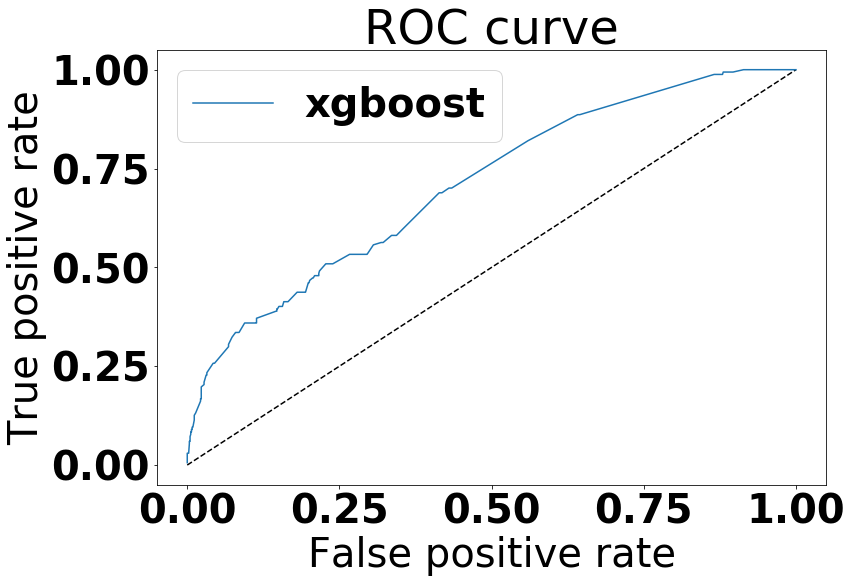

ROC AUC score:  0.708878794136


In [145]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test, preds)
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 40}

plt.rc('font', **font)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='xgboost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print("ROC AUC score: ", roc_auc_score(y_test, preds))

In [17]:
import matplotlib.pyplot as plt
# Plot Tree
plt.style.use('default') 
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 40}


#plt.figure(figsize=(12, 8))
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
fig, ax = plt.subplots(figsize=(50, 60))
plt.rcParams['figure.figsize'] = 50, 60
plt.rc('font', **font)
xgb.plot_tree(xg_reg, num_trees=0, ax=ax)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.savefig("boost_tree.png")
plt.show()

[09:10:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




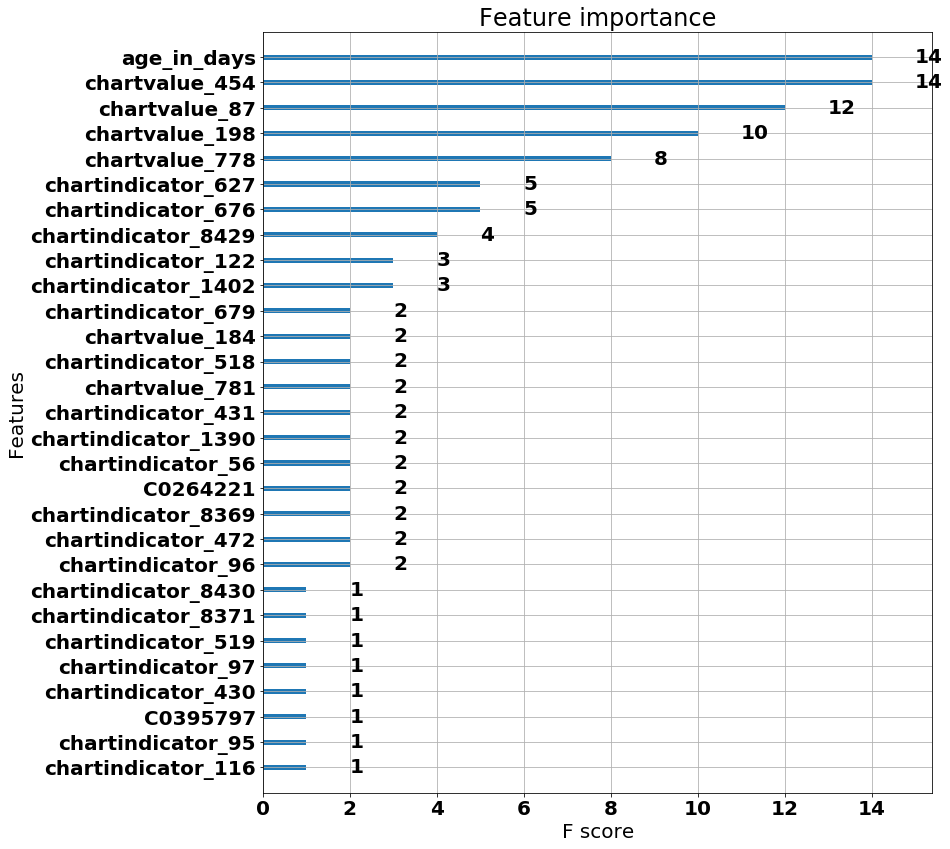

In [129]:

# Plot Feature importance
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 14]
plt.show()

#### Predictive Modeling 2 : 

In [134]:
from sklearn.linear_model import LogisticRegression
selected_features_lr = ['oxy_drop', 'age_in_days', 'chartvalue_454', 'chartvalue_87', 'chartvalue_198',
                         'chartvalue_778', 'chartindicator_627', 'chartindicator_676', 'chartindicator_116']

for fea in selected_features_lr:
    code = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].code
    description = feature_descriptions[feature_descriptions['feature']==fea].iloc[0].description
    print("feature : ", fea, "code :", code, " description ", description)


    
X = fea_and_target[selected_features_lr]
Y = fea_and_target['death_in_stay']

# Normalize features 
# transform using min max scaler
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

lr = LogisticRegression(class_weight = 'balanced', max_iter=1000)
lr.fit(X_train,y_train)
#preds = lr.predict(X_test)
preds = lr.predict_proba(X_test)[:,1]
print(preds)
preds.reshape(len(preds),)
# error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: {0} ".format(rmse))


feature :  oxy_drop code : nan  description  sustained drop in oxygenation after stable ventilation
feature :  age_in_days code : nan  description  age in days
feature :  chartvalue_454 code : 454  description  Motor Response
feature :  chartvalue_87 code : 87  description  Braden Score
feature :  chartvalue_198 code : 198  description  GCS Total
feature :  chartvalue_778 code : 778  description  Arterial PaCO2
feature :  chartindicator_627 code : 627  description  SVRI
feature :  chartindicator_676 code : 676  description  Temperature C
feature :  chartindicator_116 code : 116  description  Cardiac Index
[ 0.44134327  0.35505559  0.30399896 ...,  0.28248097  0.36774674
  0.42340737]
RMSE: 0.44389997111235036 


In [135]:
res = pd.DataFrame(data=np.array(y_test), columns=['target'])
res['prediction'] = preds
fpr, tpr, _ = roc_curve(res['target'], res['prediction'])
#res.head()

from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, lr.predict(X_test))

array([[631, 239],
       [ 66, 101]])

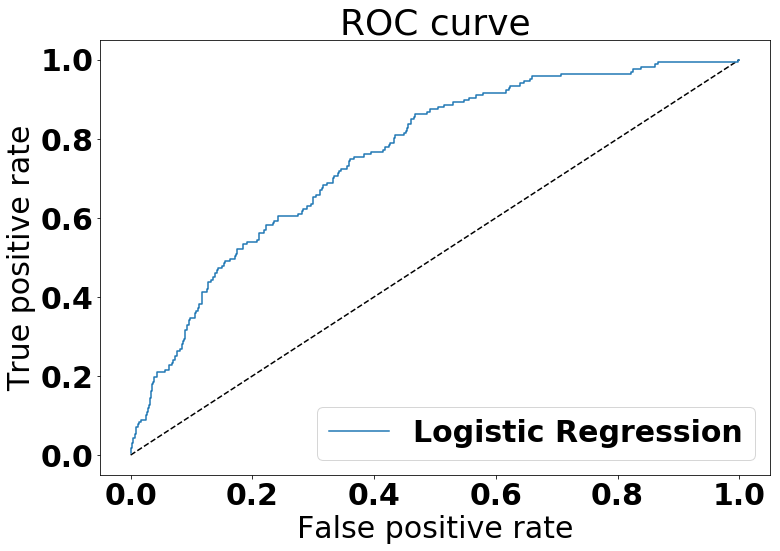

ROC AUC score:  0.756796751325


In [143]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, _ = roc_curve(y_test, preds)
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 30}

plt.rc('font', **font)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print("ROC AUC score: ", roc_auc_score(y_test, preds))

In [140]:
print("Logistic regression coefficients : ", lr.coef_)
print("Logistic regression intercept : ", lr.intercept_)

Logistic regression coefficients :  [[ 0.39227966  2.24108815 -0.90865256 -2.37057215 -0.90962588 -1.73438036
  -2.42686543 -2.10941152 -2.55343472]]
Logistic regression intercept :  [ 1.94298502]


In [176]:
f = plt.figure(figsize=(14, 10))
print(f)

[]
